# Simulation of a crack growth in a thick square plate based on Peridynamic Theory

Silling, S. A., & Askari, E. (2005). *A meshfree method based on the peridynamic model of solid mechanics*. *Computers & Structures, 83*(17-18), 1526-1535. https://doi.org/10.1016/j.compstruc.2004.11.026

## Setup

### Setup Python Modules

In this section, we will import the python libraries:

- **NumPy**: This library is fundamental for numerical computations in Python. It provides support for arrays, matrices, and many mathematical functions that operate on these data structures.
- **Matplotlib**: A plotting library for creating static, animated, and interactive visualizations in Python. It's particularly useful for generating plots, histograms, and other types of charts.
- **Pandas**: A python library used for working with data sets. It has functions for analyzing, cleaning, exploring, and manipulating data.
- **Seaborn**: This python library helps users visualize data through statistical graphics.
- **KDTree**: This python package can construct, modify and search kd-trees. A KD Tree is a space-partitioning data structure that organizes points in a k-dimensional space. It is particularly effective for multidimensional search operations such as range searches and nearest-neighbor searches. 

In [3]:
import numpy as np  
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation, PillowWriter # For animation
import pandas as pd  
import seaborn as sns
from scipy.spatial import KDTree

## Parameters

### Consistency of Units in Calculations

To avoid errors in our calculations, we will adhere to a consistent set of units for the following physical quanities:

- Length/Distance: millimeters (mm)
- Mass: kilograms (kg)
- Time: microseconds (μs)

In [4]:
"""
    Consider a 2d square plate
"""

side_length = 50 # length of one side of the square plate
nx = 40 # number of elements in x-direction
ny = 40 # number of elements in y-direction

"""
    Assign other properties
"""
rho = 8e-6 # Material density in kg/mm^3
Young_modulus = 19578.55  #  Young's Modulus in kg/mm^2
nu = 0.3 # Poisson's Ratio
K = Young_modulus/(3.0*(1-2.0*nu)) # Bulk modulus
s0 = 0.02 # critical stretch
total_time = 15
del_T = .1
time_steps = int(total_time/del_T)
ntotal = nx * ny # Total number of nodes
delta_x = 4*side_length / ntotal

# Create nodes along both axis of the square plate
nodes_xcoords = np.linspace(-side_length/2.0, side_length/2.0, nx)
nodes_ycoords = np.linspace(-side_length/2.0, side_length/2.0, ny)
y_max = nodes_ycoords[-1] # top boundary
y_min = nodes_ycoords[0] # bottom boundary
horizon = 5 

# Initialize the array to store the coordinates of all the nodes
coord_array = np.zeros((ntotal, 2))

# volume of the element
vol = (nodes_xcoords[1] - nodes_xcoords[0]) * (nodes_ycoords[1] - nodes_ycoords[0]) * 1.0

# the list to store the indices of top and bottom nodes
top_nodes = []
bottom_nodes = []
count = 0

for i in range(nx):
    for k in range(ny):

        # Assign the coordinates to the current node
        coord_array[count, 0] = nodes_xcoords[i]
        coord_array[count, 1] = nodes_ycoords[k]

        # Identify and store nodes on the top boundary (y = y_max)
        if nodes_ycoords[i] == y_max:
            bottom_nodes.append(count)

        # Identify and store nodes on the bottom boundary (y = y_min)
        if nodes_ycoords[i] == y_min:
            top_nodes.append(count)
        count = count + 1

## Boundary Conditions

<img src="fig5.png" alt="Velocity applied to plate horizontal edges" width="600">

In [5]:
u_applied_05 = np.linspace(2e-2,2e-2,time_steps//3)
u_applied_510 = np.linspace(-2e-2,-2e-2,time_steps//3)
u_applied_1015 = np.linspace(0,0,time_steps//3)
u_applied = np.concatenate((u_applied_05, u_applied_510, u_applied_1015))
print(u_applied)

[ 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02
  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02
  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02
  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02
  0.02  0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02
 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02
 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02
 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02
 -0.02 -0.02 -0.02 -0.02  0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.  ]


## Neighborsearch

We need to find for each node $x_p$ the neighborhood $H_\delta(x_p)$ such that $H_\delta(x_p)=\lbrace i | \Vert x_i - x_p \Vert \leq \delta \rbrace$.

In [6]:
def find_neighb_nodes_within_horizon(coord_array, horizon):
    # Build the KDTree
    tree = KDTree(coord_array)
    
    # Initialize the dictionary to store neighbors
    neighbors_dict = {}
    
    # Iterate over each node to find neighbors
    for i, coord in enumerate(coord_array):
        # Query the KDTree for nodes within the horizon distance
        indices = tree.query_ball_point(coord, horizon)
        # Remove the node itself from its list of neighbors
        neighbors_dict[i] = [index for index in indices if index != i]
    
    
    return neighbors_dict

neighbors_dict = find_neighb_nodes_within_horizon(coord_array, horizon)

## Displacement Calculations

In [7]:
# Initialize an array to store displacement vectors for each node at every time step
u_vector_solution = np.zeros((time_steps, nx, ny))

# Initialize an array to store the current displacement vector for each node
u_vector_at_current_time_step = np.zeros((nx, ny))

# Initialize the displacement vector at the future time step
u_vector_at_future_time_step = np.zeros((nx, ny))

# Initialize the displacement vector at the previous time step
u_vector_at_previous_time_step = np.zeros((nx, ny))

# Loop over each time step to calculate the displacement of nodes
for n in range(1, time_steps):

    # Calculate the elapsed time for the current time step
    time_elapsed = n * del_T
        
    node_values = np.zeros((nx, ny))
    
    # Assign boundary condition to the top nodes
    for index in top_nodes:
        row = index // nx
        column = index % ny
        u_vector_at_current_time_step[row, column] = u_applied[n]
        
    # Assign boundary condition to the bottom nodes
    for index in bottom_nodes:
        row = index // nx
        column = index % ny
        u_vector_at_current_time_step[row, column] = -u_applied[n]


    for x in range(nx):
        for y in range(ny):

            #Intialize the sum term
            sum_term = 0
            
            # xi represents the value of the node at the current location
            xi = u_vector_at_current_time_step[x][y] 
            xi_index = np.ravel_multi_index((x, y), u_vector_at_current_time_step.shape)
            # Get the coordinates of the node at the current location (xi)
            xi_locx = coord_array[xi_index][0] 
            xi_locy = coord_array[xi_index][1] 

            """
            We got the values for the ith nodes. Now get the neighboring nodes (xp).
            """        
            # Get neighbors for xi that fall within its horizon
            neighbors_of_xi = neighbors_dict[xi_index]

            # Loop through each neighboring node
            for p in neighbors_of_xi:
                # Get the coordinates of the neighboring node (xp)
                xp_locx = coord_array[p][0] 
                xp_locy = coord_array[p][1] 
                xp_index = p
                xp_row_id = p // ny
                xp_col_id = p % ny
                xp = u_vector_at_current_time_step[xp_row_id, xp_col_id] 

                # Skip the current node itself (xi)
                if xp_index == xi_index:
                    continue

                # Calculate the distance (ksi) between the xi and xp
                ksi = np.sqrt((xp_locx-xi_locx)**2 + (xp_locy-xi_locy)**2)

                # Calculate the difference in displacement (eta) between xi and xp
                eta = xp - xi

                # Calculate the material constant c based on bulk modulus K and horizon distance
                c = (18*K)/(np.pi * horizon**4)

                # Calculate the stretch s
                s = ((np.abs(ksi+eta)) - np.abs(ksi))/np.abs(ksi)

                # Determine the damage factor mu based on a threshold s0
                if s > s0:
                    mu = 0 # Set mu to 0 if stretch exceeds threshold, representing damage
                else:
                    mu = 1 # Set mu to 1 if no damage occurs   
                
                # calculate the summation term in the equation of motion
                sum_term = sum_term + ((((ksi+eta)/np.abs(ksi+eta)) * c * s * mu)*vol) + 9.8e-9 #(body force = 9.8 m/s^2)
            
            # calculate the acceleration
            acceleration = sum_term/rho

            # using explicit central difference formula
            u_vector_at_future_time_step[x,y] = (acceleration*del_T**2) + (2*u_vector_at_current_time_step[x,y]) - u_vector_at_previous_time_step[x, y]
            
            # update the array holding the vector solutions
            u_vector_solution[n, x, y] = u_vector_at_current_time_step[x, y]

    # update the arrays for the next iteration
    u_vector_at_previous_time_step = u_vector_at_current_time_step.copy()
    u_vector_at_current_time_step = u_vector_at_future_time_step.copy()

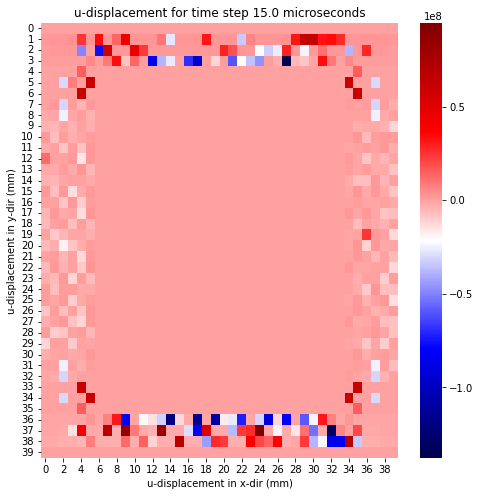

In [10]:
# set the figure size
fig, ax = plt.subplots(figsize=(8, 8))

# Find the min and max values 
vmin, vmax = np.min(u_vector_solution), np.max(u_vector_solution)

# Initialize with the first timestep
heatmap = sns.heatmap(u_vector_solution[0, :, :], cmap='seismic', ax=ax, vmin=vmin, vmax=vmax)
plt.title('u-displacement vs time')
plt.xlabel('u-displacement in x-dir (mm)')
plt.ylabel('u-displacement in y-dir (mm)')

# update the frames
def update(frame):
    ax.clear()
    heatmap = sns.heatmap(u_vector_solution[frame, :, :], cmap='seismic', ax=ax, vmin=vmin, vmax=vmax, cbar=False)
    ax.set_title(f'u-displacement for time step {(frame + 1)/10} microseconds')
    ax.set_xlabel('u-displacement in x-dir (mm)')
    ax.set_ylabel('u-displacement in y-dir (mm)')

# create the animation
anim = FuncAnimation(fig, update, frames=u_vector_solution.shape[0], interval=200)

# store the animation in .gif format
anim.save('animation2dplate.gif', writer=PillowWriter(fps=5))

plt.show()